<a href="https://colab.research.google.com/github/FranklineMisango/Deep_Learning_Projects/blob/main/Brain_Tumor_Prediction_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing the necessary libraries
#This version relies on our hard-coded value
import pandas as pd
import numpy as np
import os
import random
import warnings
import matplotlib.pyplot as plt 
import math
import shutil
import glob
import tensorflow as tf
import cv2
from tensorflow import keras
%matplotlib inline



warnings.filterwarnings('ignore')

In [ ]:
#Our Brain tumor dataset from Kaggle --> https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?resource=download
#Dowload the archive and load to collab and ran an extraction code to unzip the files
#I modified the dataset to only include the healthy & Brain tumor datasets to proceed with training & testing
#Incase of wrong folder uploads use : shutil.rmtree('/content/BrH35-Mask-Modified', ignore_errors=True)
'''
from google.colab import files

#This snippet allows the user to only extract Archives to collab's directory
uploaded = files.upload()
filename =  list(uploaded.keys())[0]
if filename.endswith('zip'):
  os.system('unzip {}'.format(filename))
elif filename.endswith('tar.gz'):
  os.system('tar -xzvf {}'.format(filename))
else:
  print("Unsupported file format")
'''

Saving Br35H_Brain_Tumor_Dataset_Archive.zip to Br35H_Brain_Tumor_Dataset_Archive.zip


In [ ]:
#Counting the number of images that we have in classes ; [Brain Tumor] & [No Brain Tumor]
#We have both 1500 for Healthy Brain and 1500 for unhealthy dataset
ROOT_DIR = "/content/Br35H_Modified"
number_of_images = {}

#This code lists the Amounts of Healthy and Non-healthy Brain Tumor Datasets
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()


dict_items([('Brain_Tumor', 1500), ('Healthy', 1500)])

In [ ]:
#Function to split the Test, Train and validation Datasets
#Train - 70%, Test - 15% and Validation - 15%
def DataFolderCreator(path,split):
  #Creating a Folder
  if not os.path.exists("./" + path):
    os.mkdir("./" + path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./" + path + "/" + dir)
      for image in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR , dir)),
                                    size = (math.floor(split * number_of_images[dir]) - 5),
                                    replace = False):
        Original = os.path.join(ROOT_DIR, dir , image)
        Destination = os.path.join("./" + path , dir)
        shutil.copy(Original, Destination)
        os.remove(Original)
  else:
    print(f"{path} Folder Already Exists")

DataFolderCreator("Train", 0.7) 
DataFolderCreator("Test", 0.15)
DataFolderCreator("Validation", 0.15)

In [ ]:
#Model building for the images
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define the model architecture as a sequence of layers
model = Sequential()

# Add the first convolutional layer with 16 filters, a 3x3 kernel size, and ReLU activation
# The input shape is set to (224, 224, 3) to match the dimensions of the input images
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))

# Add a second convolutional layer with 36 filters, a 3x3 kernel size, and ReLU activation
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
# Add a max pooling layer with a 2x2 pool size
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Add a dropout layer to help prevent overfitting
model.add(Dropout(rate=0.25))
# Flatten the output from the convolutional layers into a 1D array
model.add(Flatten())
# Add a fully connected (dense) layer with 64 units and ReLU activation
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
# Add a final dense layer with a single unit and sigmoid activation,
# which will output the predicted probability of the input image being a member of the positive class
model.add(Dense(units=1, activation='sigmoid'))

#Get gist of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
#Compiling the model 
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
#Preparing our Data Generator and loading the saved images
#1-Training Data
def preprocessingImagesTraining(path):
  #Input should be a path and output should be preprocessed images
  Image_data = ImageDataGenerator (zoom_range = 0.2 , shear_range = 0.2 , rescale = 1/255 , horizontal_flip = True)
  image = Image_data.flow_from_directory(directory = path , target_size  = (224,224), batch_size = 32 , class_mode = 'binary')

  return image

In [ ]:
path = '/content/Train'
Train_data = preprocessingImagesTraining(path)

Found 2090 images belonging to 2 classes.


In [ ]:
#Testing the data; Blueprint from the training data one 
def preprocessingImagesTesting(path):
  #Input should be a path and output should be preprocessed images
  Image_data = ImageDataGenerator (rescale = 1/255)
  image = Image_data.flow_from_directory(directory = path , target_size  = (224,224), batch_size = 32 , class_mode = 'binary')

  return image

In [ ]:
#Testing the data
path = '/content/Test'
Test_data = preprocessingImagesTesting(path)

Found 440 images belonging to 2 classes.


In [ ]:
#Validating the Images ; blueprint from testing the data one
def preprocessingImagesValidating(path):
  #Input should be a path and output should be preprocessed images
  Image_data = ImageDataGenerator (rescale = 1/255)
  image = Image_data.flow_from_directory(directory = path , target_size  = (224,224), batch_size = 32 , class_mode='binary')

  return image

In [ ]:
#Validating the data
path = '/content/Validation'
Validation_data_preprocessing = preprocessingImagesValidating(path)

Found 440 images belonging to 2 classes.


In [ ]:
#Early stopping and Model check point
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Set the callbacks for early stopping and model checkpoint
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')
mc = ModelCheckpoint(monitor='val_accuracy', filepath='./best_model.h5', verbose=1, save_best_only = True, mode='auto')
cd = [es, mc]


In [ ]:
#Model Training
#TODO--> Figure out how to determine accuracy 
#TODO--> fix the 'val_accuracy errors'
#Epochs can be adjusted to retest the images

hs = model.fit_generator(generator = Train_data, 
                              steps_per_epoch = 10, 
                              epochs = 100,
                              verbose = 1, 
                              validation_data = Validation_data_preprocessing,
                              validation_steps = 16, 
                              callbacks = cd)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9531


Epoch 1: val_accuracy improved from 0.96364 to 0.97045, saving model to ./best_model.h5
10/10 [==============================] - 12s 721ms/step - loss: 0.1280 - accuracy: 0.9531 - val_loss: 0.0848 - val_accuracy: 0.9705
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9688

10/10 [==============================] - 4s 392ms/step - loss: 0.1132 - accuracy: 0.9688
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9656

10/10 [==============================] - 4s 397ms/step - loss: 0.1038 - accuracy: 0.9656
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9781

10/10 [==============================] - 5s 521ms/step - loss: 0.0585 - accuracy: 0.9781
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9500

10/10 [==============================] - 4s 415ms/step - loss: 0.1260 - accuracy: 0.9500
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9719

10/10 [==============================] - 7s 734ms/step - loss: 0.0845 - accuracy: 0.9719
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9594

10/10 [==============================] - 4s 397ms/step - loss: 0.0856 - accuracy: 0.9594
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9750

10/10 [==============================] - 4s 394ms/step - loss: 0.0562 - accuracy: 0.9750
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9531

10/10 [==============================] - 5s 474ms/step - loss: 0.1772 - accuracy: 0.9531
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9656

10/10 [==============================] - 4s 413ms/step - loss: 0.0993 - accuracy: 0.9656
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9594

10/10 [==============================] - 5s 486ms/step - loss: 0.1132 - accuracy: 0.9594
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9656

10/10 [==============================] - 6s 524ms/step - loss: 0.0966 - accuracy: 0.9656
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9812

10/10 [==============================] - 4s 399ms/step - loss: 0.0782 - accuracy: 0.9812
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9719

10/10 [==============================] - 5s 503ms/step - loss: 0.0728 - accuracy: 0.9719
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9750

10/10 [==============================] - 5s 465ms/step - loss: 0.0663 - accuracy: 0.9750
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9812

10/10 [==============================] - 4s 412ms/step - loss: 0.0497 - accuracy: 0.9812
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9719

10/10 [==============================] - 5s 557ms/step - loss: 0.1009 - accuracy: 0.9719
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9497

10/10 [==============================] - 5s 466ms/step - loss: 0.1100 - accuracy: 0.9497
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9750

10/10 [==============================] - 4s 413ms/step - loss: 0.0566 - accuracy: 0.9750
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9688

10/10 [==============================] - 5s 505ms/step - loss: 0.0687 - accuracy: 0.9688
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9750

10/10 [==============================] - 4s 400ms/step - loss: 0.0771 - accuracy: 0.9750
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9750

10/10 [==============================] - 8s 852ms/step - loss: 0.0746 - accuracy: 0.9750
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9719

10/10 [==============================] - 4s 406ms/step - loss: 0.0641 - accuracy: 0.9719
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9844

10/10 [==============================] - 6s 540ms/step - loss: 0.0422 - accuracy: 0.9844
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9688

10/10 [==============================] - 5s 512ms/step - loss: 0.0953 - accuracy: 0.9688
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9933

10/10 [==============================] - 4s 426ms/step - loss: 0.0431 - accuracy: 0.9933
Epoch 27/100
10/10 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9844

10/10 [==============================] - 6s 520ms/step - loss: 0.0616 - accuracy: 0.9844
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9750

10/10 [==============================] - 4s 410ms/step - loss: 0.0546 - accuracy: 0.9750
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9750

10/10 [==============================] - 5s 510ms/step - loss: 0.0701 - accuracy: 0.9750
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9799

10/10 [==============================] - 4s 373ms/step - loss: 0.0600 - accuracy: 0.9799
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9530

10/10 [==============================] - 4s 385ms/step - loss: 0.1446 - accuracy: 0.9530
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9500

10/10 [==============================] - 6s 524ms/step - loss: 0.1348 - accuracy: 0.9500
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9594

10/10 [==============================] - 5s 540ms/step - loss: 0.1186 - accuracy: 0.9594
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9500

10/10 [==============================] - 4s 405ms/step - loss: 0.1148 - accuracy: 0.9500
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9875

10/10 [==============================] - 5s 517ms/step - loss: 0.0451 - accuracy: 0.9875
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9799

10/10 [==============================] - 5s 487ms/step - loss: 0.0602 - accuracy: 0.9799
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9719

10/10 [==============================] - 4s 415ms/step - loss: 0.0892 - accuracy: 0.9719
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9781

10/10 [==============================] - 4s 412ms/step - loss: 0.0552 - accuracy: 0.9781
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9906

10/10 [==============================] - 5s 492ms/step - loss: 0.0497 - accuracy: 0.9906
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9750

10/10 [==============================] - 4s 405ms/step - loss: 0.0616 - accuracy: 0.9750
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9688

10/10 [==============================] - 7s 755ms/step - loss: 0.0884 - accuracy: 0.9688
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9844

10/10 [==============================] - 4s 408ms/step - loss: 0.0458 - accuracy: 0.9844
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9765

10/10 [==============================] - 4s 374ms/step - loss: 0.0588 - accuracy: 0.9765
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9799

10/10 [==============================] - 4s 388ms/step - loss: 0.0687 - accuracy: 0.9799
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9781

10/10 [==============================] - 4s 402ms/step - loss: 0.0737 - accuracy: 0.9781
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9781

10/10 [==============================] - 5s 535ms/step - loss: 0.0430 - accuracy: 0.9781
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9875

10/10 [==============================] - 4s 414ms/step - loss: 0.0448 - accuracy: 0.9875
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9866

10/10 [==============================] - 5s 447ms/step - loss: 0.0368 - accuracy: 0.9866
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9832

10/10 [==============================] - 4s 374ms/step - loss: 0.0378 - accuracy: 0.9832
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9781

10/10 [==============================] - 5s 461ms/step - loss: 0.0657 - accuracy: 0.9781
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9875

10/10 [==============================] - 5s 419ms/step - loss: 0.0382 - accuracy: 0.9875
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9875

10/10 [==============================] - 4s 425ms/step - loss: 0.0313 - accuracy: 0.9875
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9899

10/10 [==============================] - 6s 603ms/step - loss: 0.0350 - accuracy: 0.9899
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9875

10/10 [==============================] - 4s 396ms/step - loss: 0.0356 - accuracy: 0.9875
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9812

10/10 [==============================] - 5s 454ms/step - loss: 0.0462 - accuracy: 0.9812
Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9969

10/10 [==============================] - 4s 411ms/step - loss: 0.0249 - accuracy: 0.9969
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9844

10/10 [==============================] - 5s 506ms/step - loss: 0.0461 - accuracy: 0.9844
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9719

10/10 [==============================] - 7s 698ms/step - loss: 0.1007 - accuracy: 0.9719
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9719

10/10 [==============================] - 5s 488ms/step - loss: 0.0689 - accuracy: 0.9719
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9688

10/10 [==============================] - 4s 401ms/step - loss: 0.0675 - accuracy: 0.9688
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000

10/10 [==============================] - 4s 364ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9719

10/10 [==============================] - 5s 517ms/step - loss: 0.0611 - accuracy: 0.9719
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9844

10/10 [==============================] - 4s 423ms/step - loss: 0.0673 - accuracy: 0.9844
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9781

10/10 [==============================] - 6s 591ms/step - loss: 0.0876 - accuracy: 0.9781
Epoch 65/100
10/10 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9719

10/10 [==============================] - 4s 406ms/step - loss: 0.0569 - accuracy: 0.9719
Epoch 66/100
10/10 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9781

10/10 [==============================] - 5s 522ms/step - loss: 0.0579 - accuracy: 0.9781
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9969

10/10 [==============================] - 4s 398ms/step - loss: 0.0215 - accuracy: 0.9969
Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9625

10/10 [==============================] - 4s 411ms/step - loss: 0.0709 - accuracy: 0.9625
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9844

10/10 [==============================] - 7s 666ms/step - loss: 0.0425 - accuracy: 0.9844
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9875

10/10 [==============================] - 5s 470ms/step - loss: 0.0362 - accuracy: 0.9875
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9812

10/10 [==============================] - 4s 398ms/step - loss: 0.0454 - accuracy: 0.9812
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9937

10/10 [==============================] - 4s 411ms/step - loss: 0.0322 - accuracy: 0.9937
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9656

10/10 [==============================] - 5s 528ms/step - loss: 0.0666 - accuracy: 0.9656
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9875

10/10 [==============================] - 5s 451ms/step - loss: 0.0601 - accuracy: 0.9875
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9906

10/10 [==============================] - 5s 425ms/step - loss: 0.0343 - accuracy: 0.9906
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9906

10/10 [==============================] - 4s 395ms/step - loss: 0.0323 - accuracy: 0.9906
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9906

10/10 [==============================] - 5s 521ms/step - loss: 0.0235 - accuracy: 0.9906
Epoch 78/100
10/10 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9875

10/10 [==============================] - 4s 397ms/step - loss: 0.0455 - accuracy: 0.9875
Epoch 79/100
10/10 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9875

10/10 [==============================] - 6s 491ms/step - loss: 0.0444 - accuracy: 0.9875
Epoch 80/100
10/10 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9781

10/10 [==============================] - 4s 398ms/step - loss: 0.0738 - accuracy: 0.9781
Epoch 81/100
10/10 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9844

10/10 [==============================] - 5s 517ms/step - loss: 0.0497 - accuracy: 0.9844
Epoch 82/100
10/10 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9875

10/10 [==============================] - 4s 397ms/step - loss: 0.0287 - accuracy: 0.9875
Epoch 83/100
10/10 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9750

10/10 [==============================] - 5s 509ms/step - loss: 0.0776 - accuracy: 0.9750
Epoch 84/100
10/10 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9966

10/10 [==============================] - 5s 499ms/step - loss: 0.0241 - accuracy: 0.9966
Epoch 85/100
10/10 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9844

10/10 [==============================] - 5s 491ms/step - loss: 0.0504 - accuracy: 0.9844
Epoch 86/100
10/10 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9844

10/10 [==============================] - 4s 400ms/step - loss: 0.0376 - accuracy: 0.9844
Epoch 87/100
10/10 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9750

10/10 [==============================] - 4s 395ms/step - loss: 0.0762 - accuracy: 0.9750
Epoch 88/100
10/10 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9866

10/10 [==============================] - 5s 483ms/step - loss: 0.0449 - accuracy: 0.9866
Epoch 89/100
10/10 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9969

10/10 [==============================] - 4s 401ms/step - loss: 0.0162 - accuracy: 0.9969
Epoch 90/100
10/10 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9906

10/10 [==============================] - 4s 401ms/step - loss: 0.0233 - accuracy: 0.9906
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9844

10/10 [==============================] - 5s 426ms/step - loss: 0.0693 - accuracy: 0.9844
Epoch 92/100
10/10 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9812

10/10 [==============================] - 4s 394ms/step - loss: 0.0523 - accuracy: 0.9812
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9812

10/10 [==============================] - 5s 512ms/step - loss: 0.0556 - accuracy: 0.9812
Epoch 94/100
10/10 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9875

10/10 [==============================] - 4s 389ms/step - loss: 0.0320 - accuracy: 0.9875
Epoch 95/100
10/10 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9875

10/10 [==============================] - 4s 394ms/step - loss: 0.0325 - accuracy: 0.9875
Epoch 96/100
10/10 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9906

10/10 [==============================] - 5s 433ms/step - loss: 0.0289 - accuracy: 0.9906
Epoch 97/100
10/10 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9765

10/10 [==============================] - 4s 360ms/step - loss: 0.0713 - accuracy: 0.9765
Epoch 98/100
10/10 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9937

10/10 [==============================] - 5s 539ms/step - loss: 0.0258 - accuracy: 0.9937
Epoch 99/100
10/10 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9937

10/10 [==============================] - 5s 490ms/step - loss: 0.0192 - accuracy: 0.9937
Epoch 100/100
10/10 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9844

10/10 [==============================] - 4s 414ms/step - loss: 0.0493 - accuracy: 0.9844


In [ ]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

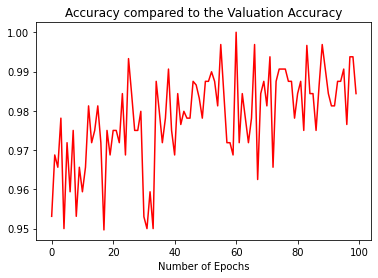

In [ ]:
#Model perfomance and Graphical intepretation; Overfitting check
#TODO; How to compare accuracy with val accuracy; which is not showing as the blue line
#1 --> Accuracy
plt.plot(h['accuracy'], c = "red")
plt.plot(h['val_accuracy'], c = "blue")
plt.xlabel("Number of Epochs")
plt.title("Accuracy compared to the Valuation Accuracy")
plt.show()

In [ ]:
#Model Accuracy
from keras.models import load_model

model = load_model("/content/best_model.h5")
accuracy = model.evaluate_generator(Test_data)[1]
print(f"The Accuracy of This Model is {accuracy * 100} %")


The Accuracy of This Model is 98.86363744735718 %


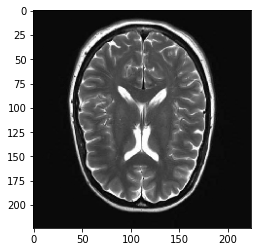

1/1 [==============================] - 0s 20ms/step
The MRI Image has a tumor


In [ ]:
#Test the model with a random image
#The testing is done with the untouched original dataset -> commit
#TODO -> Fix the image prediction slice, its wrong as you can see below
path = "/content/Train/Healthy/No12.jpg"
image = load_img(path, target_size = (224, 224))
input_array = img_to_array(image) / 255
plt.imshow(input_array)
plt.show()
input_array.shape
input_array = np.expand_dims(input_array, axis = 0)
Train_data.class_indices
prediction = np.argmax(model.predict(input_array))
prediction
if prediction == 0:
  print("The MRI Image has a tumor")
else:
  print("The MRI does not have a tumor")